In [2]:
import os
import sys
from pathlib import Path
django_project_dir = Path(".")
sys.path.insert(0, str(django_project_dir))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "newsilkroad.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import django
django.setup()

[raven.contrib.django.client.DjangoClient]DEBUG 13:02:20 Configuring Raven for host: None
[raven.contrib.django.client.DjangoClient]INFO 13:02:20 Raven is not configured (logging is disabled). Please see the documentation for more information.


In [3]:
import pandas as pd
import geopandas
import matplotlib
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt

from django.db import connection

from infrastructure.models import Project
from locations.models import GeometryStore

## Asia

<AxesSubplot:>

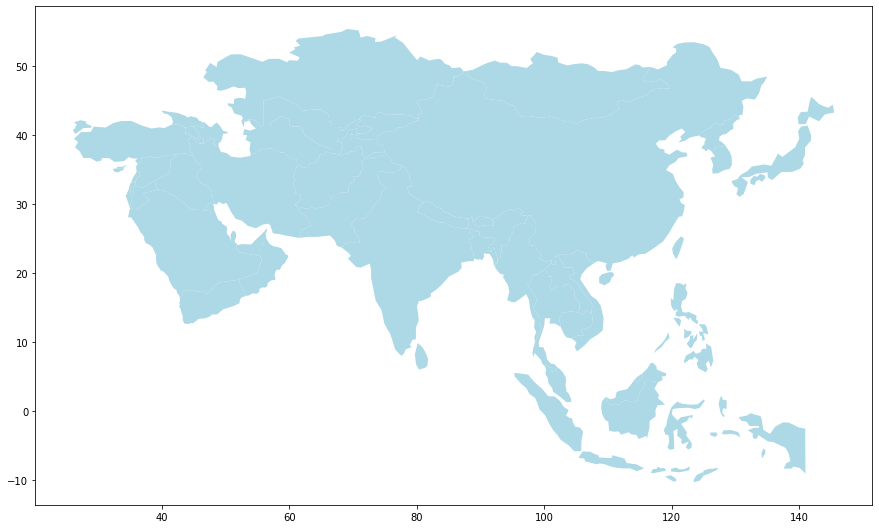

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
asia = world[world.continent == 'Asia']
asia.plot(figsize=(15,10), color='lightblue')

# Project Centroids

In [5]:
df = pd.DataFrame(Project.objects.values("identifier", "geo__centroid"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14175 entries, 0 to 14174
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   identifier     14175 non-null  object
 1   geo__centroid  9447 non-null   object
dtypes: object(2)
memory usage: 221.6+ KB


In [6]:
# convert geo__centroid to Point
df["centroid"] = df['geo__centroid'].dropna().apply(Point)

In [7]:
# convert to GeoDataFrame using centroid column as geometry
df = geopandas.GeoDataFrame(df, geometry='centroid')
df.head()

,identifier,geo__centroid,centroid
0,dbf32433-5c1a-45ef-8b01-f9b4d14ec14a,None,None
1,61c2e46e-143b-44de-8603-245d7df6f222,"[69.38632282172752, 35.0225749028977]",POINT (69.38632 35.02257)
2,8c99867a-0021-4883-a2b3-b24e54d5f294,"[68.7531764137017, 33.68524636471736]",POINT (68.75318 33.68525)
3,537ffe47-9cb6-4293-9b96-9db5fecf677e,"[67.14828420467336, 35.28156348223486]",POINT (67.14828 35.28156)
4,5021b5b0-4c8f-444d-a14c-7da795cdfb8f,"[71.31405183898606, 36.957085267575174]",POINT (71.31405 36.95709)


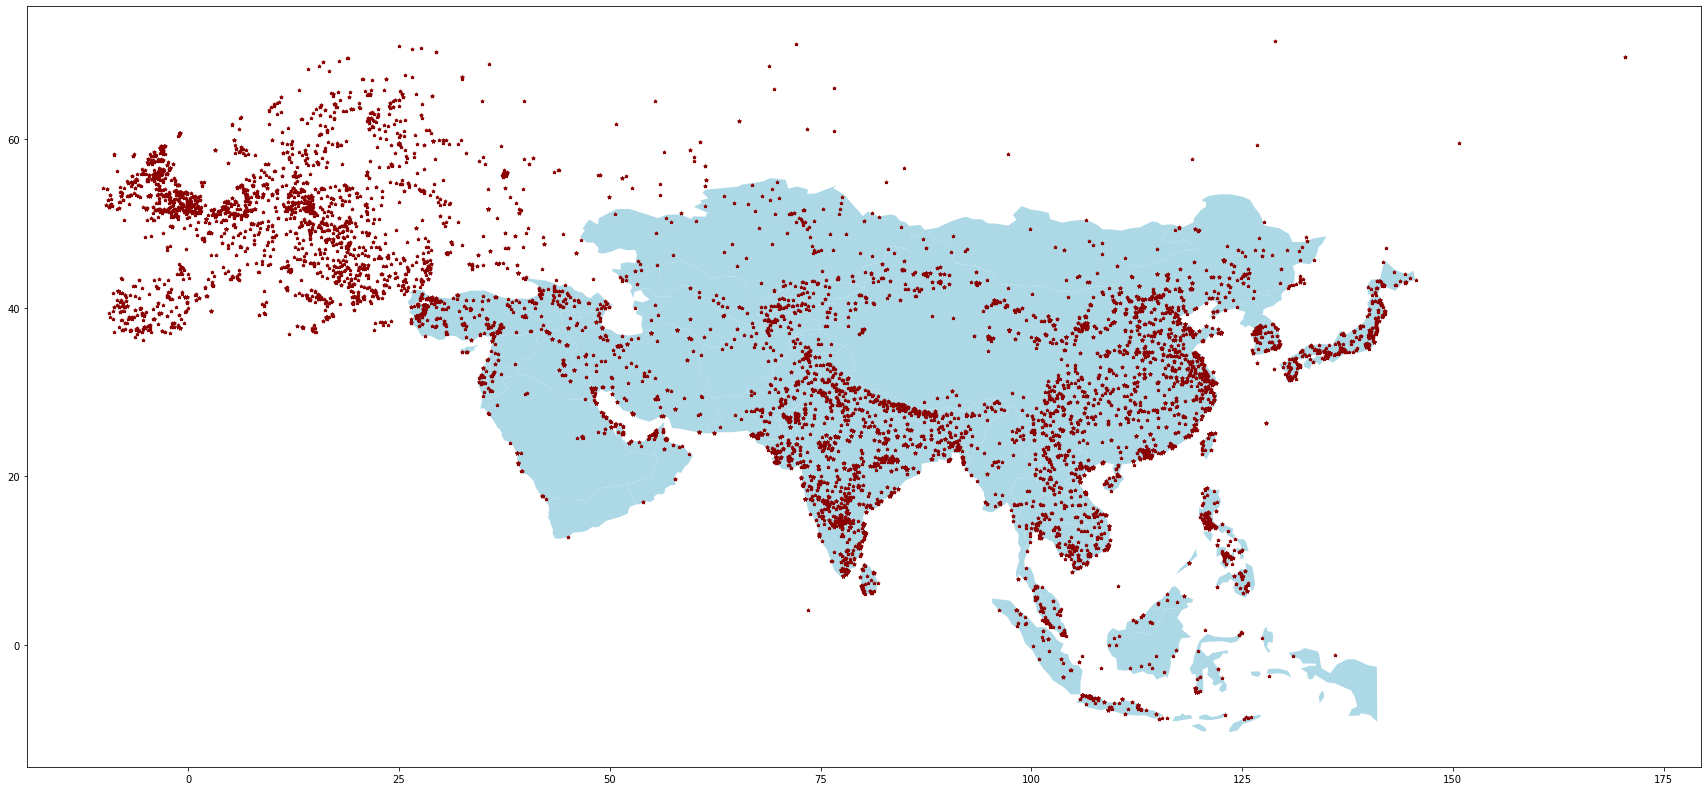

In [8]:
# create base plot with asia
fig, ax = plt.subplots(1, figsize=(30,20))
base = asia.plot(ax=ax, color='lightblue')

# plot cenroids on top with red color to stand out
df.plot(ax=base, color='darkred', marker="*", markersize=10);

## Lines

In [9]:
lines = pd.DataFrame(Project.objects.values("identifier", "geo__lines__attributes", "geo__lines__geom"))
points = pd.DataFrame(Project.objects.values("identifier", "geo__points__attributes", "geo__points__geom"))
centroids = pd.DataFrame(Project.objects.values("identifier", "geo__centroid"))
ids = pd.DataFrame(Project.objects.values("identifier", "geo__label"))

In [14]:
def _convert_geom(geom, converter):
    if geom:
        if converter == "line":
            return LineString(geom)
        if converter == "point":
            return Point(geom)

In [44]:
project = pd.DataFrame(Project.objects.values("identifier", "geo__lines__geom", "geo__points__geom", "geo__centroid"))
project["geo__lines__geom"] = project["geo__lines__geom"].apply(_convert_geom, args=("line",))
project["geom"] = project["geo__centroid"].apply(_convert_geom, args=("point",))
project["geo__points__geom"] = project["geo__points__geom"].apply(_convert_geom, args=("point",))

In [49]:
project_view = pd.read_sql("SELECT * FROM infrastructure_projects_export_view;", connection)
merged_project = project_view.merge(project, on='identifier')
merged_project['identifier'] = merged_project['identifier'].apply(str)
gdf = geopandas.GeoDataFrame(merged_project, geometry="geom")
gdf.info()
gdf.to_file("shapefiles/combined/combined.json", driver="GeoJSON")

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 16551 entries, 0 to 16550
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   identifier                     16551 non-null  object  
 1   name                           16551 non-null  object  
 2   infrastructure_type            16545 non-null  object  
 3   countries                      16548 non-null  object  
 4   regions                        16492 non-null  object  
 5   contractors                    4555 non-null   object  
 6   initiatives                    1778 non-null   object  
 7   operators                      1334 non-null   object  
 8   funding_sources                2636 non-null   object  
 9   funding_amounts                2636 non-null   object  
 10  funding_currencies             2636 non-null   object  
 11  fuel_type                      11578 non-null  object  
 12  fuel_category           

ValueError: Invalid field type <class 'django.contrib.gis.geos.point.Point'>

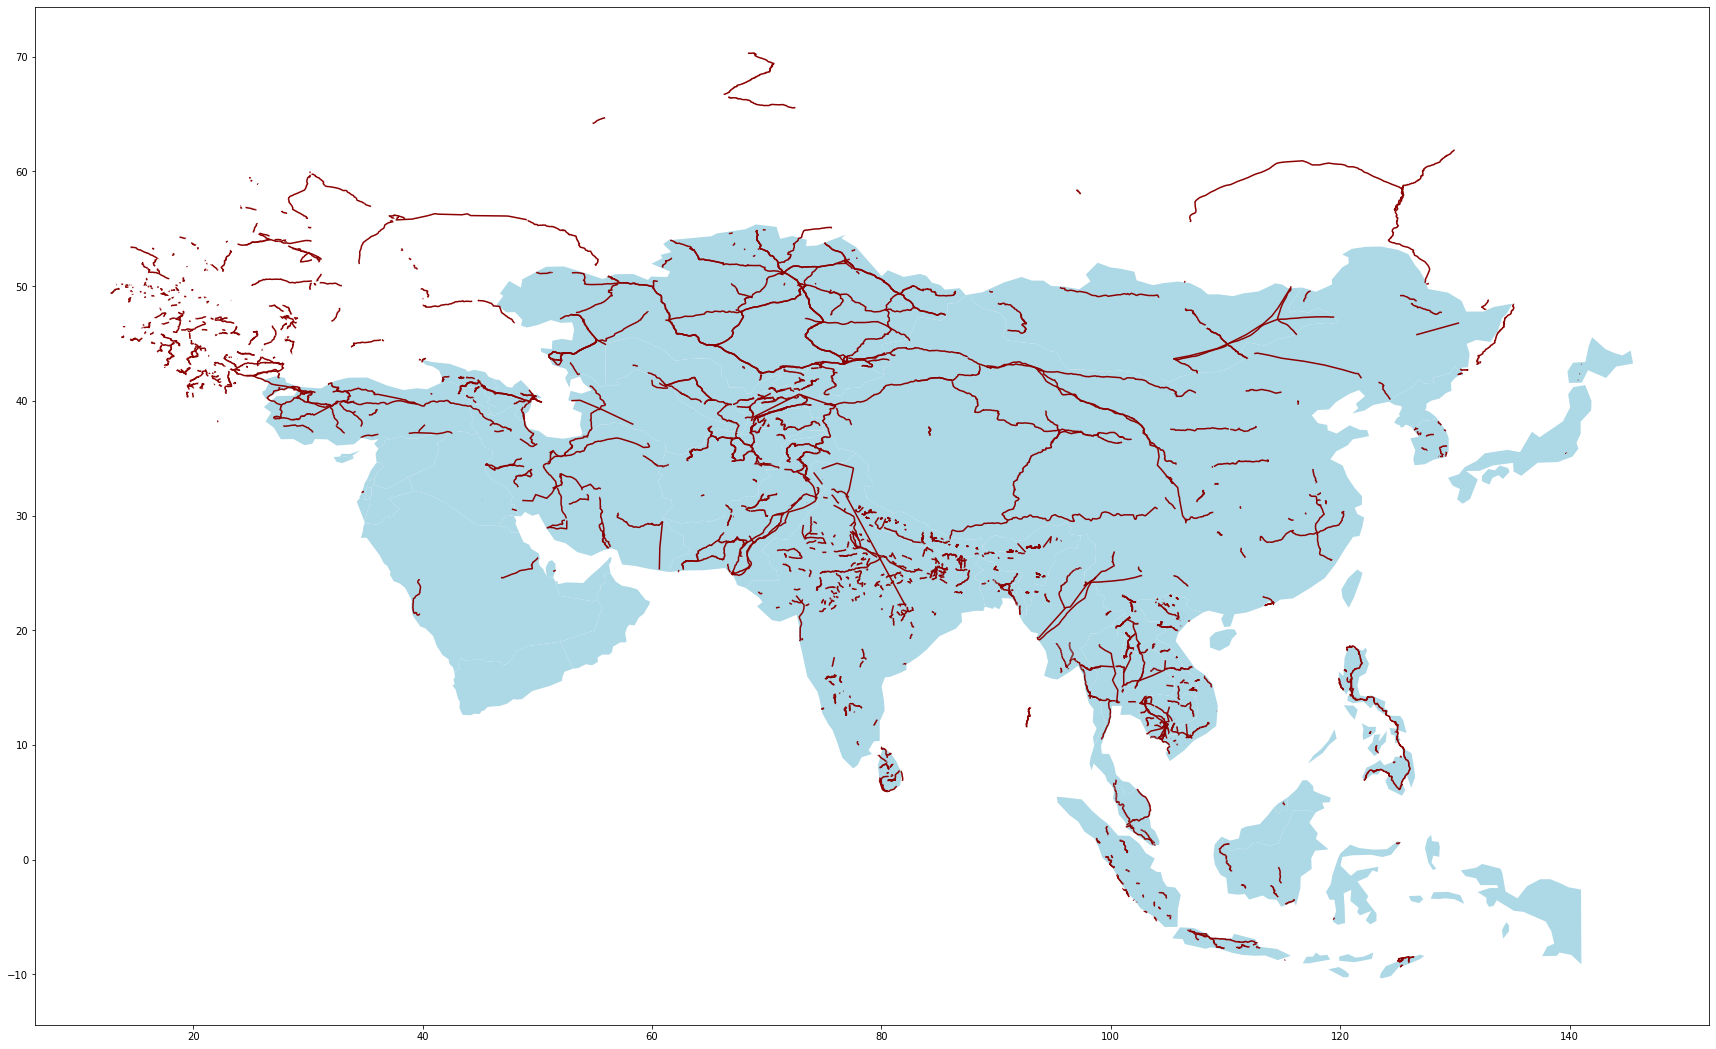

In [45]:
# create base plot with asia
fig, ax = plt.subplots(1, figsize=(30,20))
base = asia.plot(ax=ax, color='lightblue')

# plot cenroids on top with red color to stand out
lines.plot(ax=base, color='darkred', marker="*", markersize=10);

In [47]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15795 entries, 0 to 15794
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   identifier        15795 non-null  object  
 1   geo__lines__geom  2704 non-null   object  
 2   lines             2704 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 370.3+ KB


# infrastructure_projects_export_view

In [34]:
with connection.cursor() as cursor:
    projects = pd.read_sql("SELECT * FROM infrastructure_projects_export_view;", connection)

In [35]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14175 entries, 0 to 14174
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   identifier                     14175 non-null  object 
 1   name                           14175 non-null  object 
 2   infrastructure_type            14169 non-null  object 
 3   countries                      14172 non-null  object 
 4   regions                        14120 non-null  object 
 5   contractors                    3959 non-null   object 
 6   initiatives                    1156 non-null   object 
 7   operators                      754 non-null    object 
 8   funding_sources                1547 non-null   object 
 9   funding_amounts                1547 non-null   object 
 10  funding_currencies             1547 non-null   object 
 11  fuel_type                      10970 non-null  object 
 12  fuel_category                  10970 non-null 

In [57]:
output = projects.merge(lines, on="identifier")
output = geopandas.GeoDataFrame(output, geometry='geometry')
output.head()

,identifier,name,infrastructure_type,countries,regions,contractors,initiatives,operators,funding_sources,funding_amounts,...,pipeline_throughput_unit,pipeline_throughput_timeframe,pipeline_throughput_year,design_voltage,direct_current,electricity_flow,estimated_transfer_capacity,geo__lines__geom,lines,geometry
0,1de2c76a-9775-43a4-9d9f-c7cf61538d17,North-South Road Transport Corridor (Phase 4),Road,'Armenia',"'Russia, Central Asia and the South Caucasus'",None,'International North-South Transport Corridor',None,'Eurasian Development Bank' 'European Investme...,150000000 NULL,...,,,None,NaN,None,None,NaN,None,None,None
1,9d46759b-4222-42f6-a5b7-b0c4430f38e7,M6 Vanadzor-Alaverdi-Georgia Interstate Road R...,Road,'Armenia',"'Russia, Central Asia and the South Caucasus'",None,None,None,'European Investment Bank (EIB)' 'Armenia' 'As...,51000000 50000000 225000,...,,,None,NaN,None,None,NaN,None,None,None
2,a0050ef7-7d37-4a41-b4e8-9d88a27f1d7d,East-West Highway Improvement,Road,'Azerbaijan',"'Russia, Central Asia and the South Caucasus'","'Impresa S.p.A.', 'Polat Yol Yapı San. ve Tic....",'Transport Corridor Europe-Caucasus-Asia (TRAC...,'Azeravtoyol OJSC','Azerbaijan' 'Islamic Development Bank' 'Asian...,73800000 10400000 40400000 13000000,...,,,None,NaN,None,None,NaN,"[(47.1473271242765, 40.59867436283687), (47.14...","LINESTRING (47.14733 40.59867, 47.14183 40.599...","LINESTRING (47.14733 40.59867, 47.14183 40.599..."
3,a0050ef7-7d37-4a41-b4e8-9d88a27f1d7d,East-West Highway Improvement,Road,'Azerbaijan',"'Russia, Central Asia and the South Caucasus'","'Impresa S.p.A.', 'Polat Yol Yapı San. ve Tic....",'Transport Corridor Europe-Caucasus-Asia (TRAC...,'Azeravtoyol OJSC','Azerbaijan' 'Islamic Development Bank' 'Asian...,73800000 10400000 40400000 13000000,...,,,None,NaN,None,None,NaN,"[(45.34672354964263, 41.08873304090381), (45.3...","LINESTRING (45.34672 41.08873, 45.34541 41.092...","LINESTRING (45.34672 41.08873, 45.34541 41.092..."
4,729efb76-3a6c-4879-871e-45b9685821df,Highway 2,Road,'Azerbaijan',"'Russia, Central Asia and the South Caucasus'","'Makyol İnşaat A.Ş.', 'KOLIN Construction, Tou...",'Azerbaijan State Programme on Poverty Reducti...,None,'International Bank for Reconstruction and Dev...,200000000 64870000,...,,,None,NaN,None,None,NaN,"[(48.15204805487743, 40.33573778336805), (48.1...","LINESTRING (48.15205 40.33574, 48.14465 40.337...","LINESTRING (48.15205 40.33574, 48.14465 40.337..."


In [60]:
output.to_file("foo.shp")

TypeError: Cannot interpret '<geopandas.array.GeometryDtype object at 0x1247cf4a8>' as a data type

In [61]:
output.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15795 entries, 0 to 15794
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   identifier                     15795 non-null  object  
 1   name                           15795 non-null  object  
 2   infrastructure_type            15789 non-null  object  
 3   countries                      15792 non-null  object  
 4   regions                        15736 non-null  object  
 5   contractors                    4373 non-null   object  
 6   initiatives                    1769 non-null   object  
 7   operators                      1332 non-null   object  
 8   funding_sources                2621 non-null   object  
 9   funding_amounts                2621 non-null   object  
 10  funding_currencies             2621 non-null   object  
 11  fuel_type                      10970 non-null  object  
 12  fuel_category           

In [63]:
type(output['geo__lines__geom'])

pandas.core.series.Series